In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220726_20 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220726_20"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (C): Embedding(78, 20)
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(60, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220726_20", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7647564251486625]
max_auc_mean: 0.7647564251486625, max_auc_std: 0.0
max_auc_dir: 01


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7642675819364979]
max_fin_auc_mean: 0.7642675819364979, max_auc_std: 0.0
max_fin_auc_dir: 01


In [7]:
test_dataset[3]

(array([29, 29, 29, ..., 76, 76, 76]),
 array([2, 2, 3, ..., 4, 4, 4]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [32]:
# 3, 6
c3_seq, d_seq, r_seq = test_dataset[3]

view_from = 400
view_to = 500

seq_len = view_to - view_from

c3_seq = [c3_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C3_seq: [batch_size, seq_len, num_c4]

# beta3_seq: [batch_size, seq_len]
beta3_seq = torch.gather(C3_seq, dim=-1, index=LongTensor(c3_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_beta_seq = torch.sigmoid(beta3_seq).detach().cpu().numpy()[0]

sigmoid_beta_gamma_seq = torch.sigmoid(beta3_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

# C3_seq = C3_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

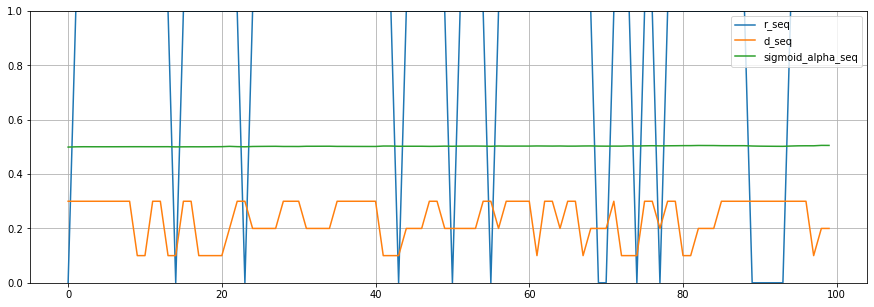

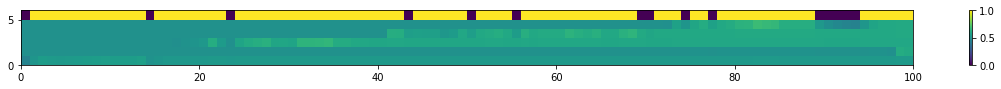

In [33]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_beta_seq")
# plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_beta_gamma_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [34]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.44810587, 0.49934068, 0.49934068, 0.49934068, 0.49934068],
      dtype=float32)

In [35]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.53966796, 0.6049254 , 0.59617424, 0.6026022 , 0.6019839 ],
      dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([ 8, 17, 26, 27, 29, 40, 42, 50, 55, 71, 73, 75, 76]),
 [array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 73, 73, 73, 73, 73, 73,
         73, 73, 73, 73, 73, 73, 73, 73, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 4

In [13]:
dataset.c3_list[np.unique(c3_seq)]

array(['01 명제와 조건', '01 유리식', '01 집합의 뜻과 표현', '01 집합의 연산', '01 함수',
       '02 명제의 역, 대우', '02 부분집합', '02 여러 가지 함수', '02 원소의 개수',
       '03 충분조건과 필요조건', '03 합성함수', '04 역함수', '04 절대부등식'], dtype=object)

In [14]:
dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]

'03 합성함수'

In [15]:
dataset.c32c4_list[dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]]

['[10] 합성함수',
 '[11] fоg=gоf인 경우',
 '[12] fоf에 대한 조건이 주어진 경우',
 '[13] fоg=h를 만족시키는 함수 f 또는 g 구하기',
 '[14] 합성함수의 추정',
 '[24] 합성함수에 대한 방정식이 주어진 경우',
 '[25] 합성함수 + 인수정리',
 '[26] 합성함수 + 역함수']

In [16]:
d_seq

[array([2, 2, 3, 3, 3, 3, 4, 2, 2, 4, 4, 3, 2, 4, 2, 2, 3, 2, 3, 4, 3, 3,
        3, 3, 3, 3, 2, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 4, 2, 3,
        2, 3, 2, 3, 4, 4, 4, 3, 2, 2, 3, 2, 2, 3, 2, 3, 4, 4, 2, 3, 3, 3,
        4, 2, 3, 4, 4, 3, 3, 3, 3, 3, 4, 2, 3, 4, 2, 3, 4, 4, 2, 3, 2, 3,
        3, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1,
        1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0,
        0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 

In [17]:
model.D.weight

Parameter containing:
tensor([[-0.2392],
        [-0.4827],
        [-0.3342],
        [-0.2720],
        [-0.2518],
        [-0.2460],
        [ 0.0264]], requires_grad=True)

In [18]:
h_seq.shape

torch.Size([1, 1000, 20])

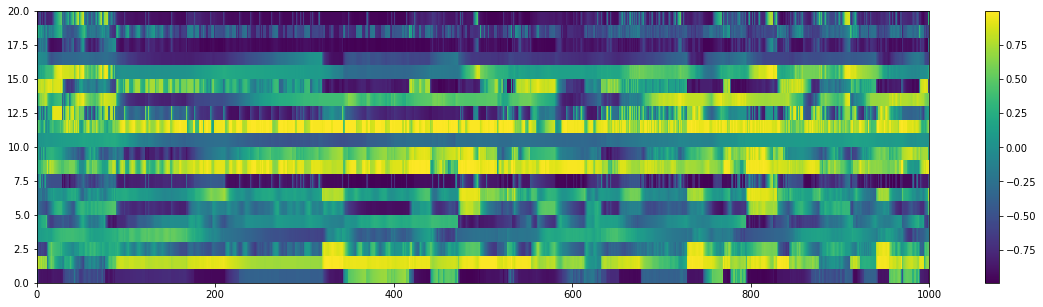

In [19]:
plt.figure(figsize=[20, 5], facecolor="white")
plt.pcolormesh(h_seq[0].detach().cpu().numpy().T)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [20]:
dataset.c22c3_list

{'01 다항식의 연산': ['01 다항식의 연산', '02 다항식의 곱셈공식', '03 다항식의 나눗셈'],
 '01 삼각비': ['소단원'],
 '01 제곱근과 실수': ['소단원'],
 '01 지수': ['01 거듭제곱과 거듭제곱근', '02 지수의 확장'],
 '01 집합의 뜻과 표현': ['01 집합의 뜻과 표현', '02 부분집합'],
 '01 함수의 극한': ['01 함수의 극한', '02 함수의 극한에 대한 성질', '03 함수의 극한의 응용'],
 '02 로그': ['01 로그의 뜻과 성질', '02 상용로그'],
 '02 삼각형의 외심과 내심': ['소단원'],
 '02 집합의 연산': ['01 집합의 연산', '02 원소의 개수'],
 '02 함수의 연속': ['01 함수의 연속', '02 연속함수의 성질'],
 '02 항등식과 나머지정리': ['01 항등식', '02 나머지정리와 인수정리'],
 '03 명제': ['01 명제와 조건', '02 명제의 역, 대우', '03 충분조건과 필요조건', '04 절대부등식'],
 '03 미분계수와 도함수': ['01 미분계수', '02 도함수'],
 '03 원과 직선': ['소단원'],
 '03 인수분해': ['01 인수분해'],
 '03 지수함수': ['01 지수함수의 뜻과 그래프', '02 지수함수의 최대 · 최소', '03 지수함수의 활용'],
 '04 도함수의 활용(1)': ['01 접선의 방정식', '02 평균값 정리'],
 '04 로그함수': ['01 로그함수의 뜻과 그래프', '02 로그함수의 최대 · 최소', '03 로그함수의 활용'],
 '04 복소수': ['01 복소수의 성질과 연산', '02 i의 거듭제곱, 음수의 제곱근'],
 '04 원주각': ['소단원'],
 '04 함수': ['01 함수', '02 여러 가지 함수', '03 합성함수', '04 역함수'],
 '05 대푯값과 산포도': ['소단원'],
 '05 도함수의 활용(2)': ['01 함수의 증가와 감소', '02 함수

In [21]:
c2 = "01 집합의 뜻과 표현"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.500944], dtype=float32), array([0.50011384], dtype=float32))

In [22]:
c2 = "04 함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5193426], dtype=float32), array([0.5276481], dtype=float32))

In [23]:
c2 = "05 유리함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.500944], dtype=float32), array([0.49387506], dtype=float32))

In [24]:
dataset.num_c3

78

In [25]:
C3_seq.shape

torch.Size([1, 1000, 78])

In [26]:
model.eval()
alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

model.eval()
alpha_seq_0, h_seq_0, C3_seq_0 = model(
    LongTensor(c3_seq)[:, :50],
    LongTensor(d_seq)[:, :50],
    LongTensor(r_seq)[:, :50],
)

alpha_seq_1, h_seq_1, C3_seq_1 = model(
    LongTensor(c3_seq)[:, 50:],
    LongTensor(d_seq)[:, 50:],
    LongTensor(r_seq)[:, 50:],
    h_seq_0[:, -1, :],
    C3_seq_0[:, -1, :],
)

alpha_seq_2 = torch.cat([alpha_seq_0, alpha_seq_1], dim=-1)
h_seq_2 = torch.cat([h_seq_0, h_seq_1], dim=1)
C3_seq_2 = torch.cat([C3_seq_0, C3_seq_1], dim=1)

In [27]:
(alpha_seq - alpha_seq_2).max(), (h_seq - h_seq_2).max(), (C3_seq - C3_seq_2).max()

(tensor(4.6566e-10, grad_fn=<MaxBackward1>),
 tensor(1.7881e-07, grad_fn=<MaxBackward1>),
 tensor(5.9605e-08, grad_fn=<MaxBackward1>))

In [28]:
print(np.random.normal(size=[20]))

[-0.4686275   0.81961096  0.26310364 -0.49727661 -0.75889861  0.35980909
  1.79629065  0.64195513 -0.77787265  0.13080078 -0.89405907  0.82217637
 -2.06672557 -0.09708752  0.67215209 -0.09670705 -3.27276116 -1.21543244
 -0.86615448  1.93533762]


In [29]:
np.random.normal(size=[dataset.num_c3])

array([ 0.34135644, -1.71514106,  0.06744426, -0.40841698, -0.25133054,
       -1.10684477,  0.36832283, -0.05812999, -0.54386032, -1.11487364,
       -0.07037182, -1.48621112,  0.19298491, -0.87022744, -1.37279009,
        1.02116663, -0.93433904, -0.51978587,  0.84805416, -0.63909378,
       -0.40353292, -0.71439201,  0.96979368,  1.06704536,  0.39759371,
        0.54795224,  1.38222362, -0.81439776,  1.16378078,  0.46865638,
       -0.08423266, -0.84393506,  0.97993971, -0.47032791,  0.95565462,
       -0.46911   , -0.89675983,  1.29457851, -0.74217336,  1.53294448,
       -0.50573291,  0.79820318,  0.83072697,  1.43383422,  1.17702309,
        0.60393891,  1.95863498,  2.08668634, -0.32760125, -0.30375242,
        0.8984808 ,  0.25646887,  0.53144828,  0.40815484,  0.08078391,
        1.41177099,  1.69093232,  1.86924591, -1.6309202 , -0.12322131,
        0.69779754,  0.2552608 ,  1.02702909,  0.51656541,  1.33591089,
       -0.38616086,  0.92878774,  0.48189563,  0.58529092,  1.72